Fitting just a Polya model to the integral histograms to extract the peak and calculate the gain. This plots a histogram and extracts for each voltage. 

For high voltage (1950, 2000V) mask data so that it doesnt see the low charge values and get dragged backwards by the noise peak. 

In [13]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import glob
import re
from scipy.special import gamma
import matplotlib.pyplot as plt


spe_files = glob.glob('PMT5/Proc_Clean_PMT5/*.csv')
darkrate_files = glob.glob('PMT5/DarkRate_PMT5/*.csv')

print("SPE files found:")
for f in spe_files:
    print(" ", f)

print("\nDark rate files found:")
for f in darkrate_files:
    print(" ", f)

SPE files found:
  PMT5/Proc_Clean_PMT5/270126_spe_1950_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1850_500_2_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1850_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1800_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1900_500_2_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1900_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1750_500_2_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1750_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_2000_500_1_on_ch1_processed_cleaned.csv
  PMT5/Proc_Clean_PMT5/270126_spe_1750_500_4_on_ch1_processed_cleaned.csv

Dark rate files found:
  PMT5/DarkRate_PMT5/260126_darkrate_1850_10000_4_on_processed_threshold15_cleaned.csv
  PMT5/DarkRate_PMT5/260126_darkrate_1900_10000_4_on_processed_threshold15_cleaned.csv
  PMT5/DarkRate_PMT5/260126_darkrate_1750_100

In [14]:
# Adding polya distribution to pulse integral graph

def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF

def fit_polya_and_get_peak(all_integrals_picocharge, bin_cut, Delta_x=0.1, filename=None):

    positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]
    int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x) #each bin is 0.1pC
    n, bins = np.histogram(positive_charge_data, bins=int_number_of_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    mask = bin_centers >= bin_cut
    n_fit = n[mask]
    bin_centers_fit = bin_centers[mask]

    # Only data above bin_cut for initial guesses
    positive_charge_data_cut = positive_charge_data[positive_charge_data >= bin_cut]

    initial_nbar = np.mean(positive_charge_data_cut)
    initial_var = np.var(positive_charge_data_cut) 

    N_events = len(positive_charge_data)
    
    initial_A = N_events * Delta_x
    initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

    p0 = [initial_A, initial_nbar, initial_theta]

    popt, pcov = curve_fit(polya_dist, bin_centers_fit, n_fit , p0=p0, absolute_sigma=True, maxfev=10000)
    A_fit, nbar_fit, theta_fit = popt
    err_A = np.sqrt(pcov[0, 0])
    err_nbar = np.sqrt(pcov[1, 1])
    err_theta = np.sqrt(pcov[2, 2])
    polya_dist_fit = polya_dist(bin_centers, *popt)

    peak = (theta_fit / (theta_fit + 1)) * nbar_fit
    dpeak_dnbar = theta_fit / (theta_fit + 1)
    dpeak_dtheta = nbar_fit / (theta_fit + 1)**2

    peak_err = np.sqrt((dpeak_dnbar * err_nbar)**2 + (dpeak_dtheta * err_theta)**2 + 2*dpeak_dnbar*dpeak_dtheta*pcov[1,2])

    #chi squared, bins with zero counts must be accounted for otherwise divide by zero error and chi squared -> infinity
    model_fit = polya_dist(bin_centers_fit, *popt)
    valid = n_fit > 0
    chi2 = np.sum((n_fit[valid] - model_fit[valid])**2 / n_fit[valid])
    ndof = np.sum(valid) - len(popt)
    chi2_red = chi2 / ndof

    plt.figure(figsize=(6,6))
    plt.bar(bin_centers, n, width=Delta_x, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_cut, 20, 500)
    plt.plot(x_fit, polya_dist(x_fit, *popt), 'r-', lw=2, label=rf'Polya fit, $\chi^2_\nu={chi2_red:.2f}$')
    plt.axvline(peak, color='k', linestyle='--', label=rf'Peak = ${peak:.3f}\pm{peak_err:.3f}$ pC')
    plt.xlim(0, 20)
    plt.xlabel('Charge (pC)')
    plt.ylabel('Counts')
    if filename is not None:
        plt.title(os.path.basename(filename)) 
    else:
        plt.title('Polya fit to pulse integral histogram')
    plt.legend()
    plt.show()

    return peak, peak_err


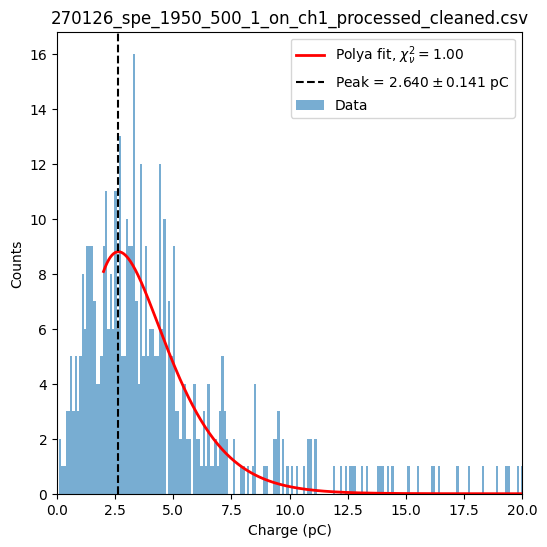

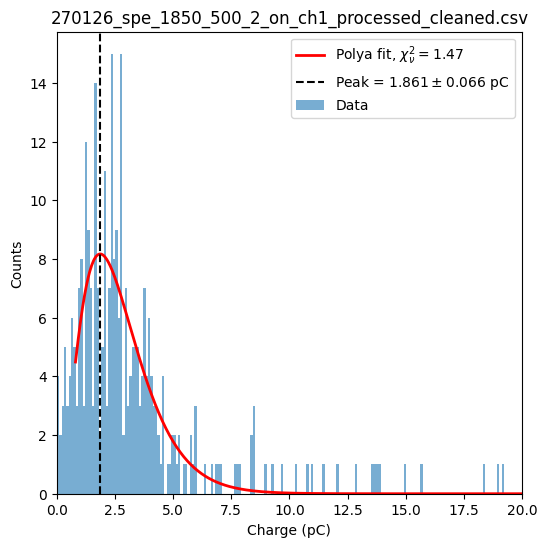

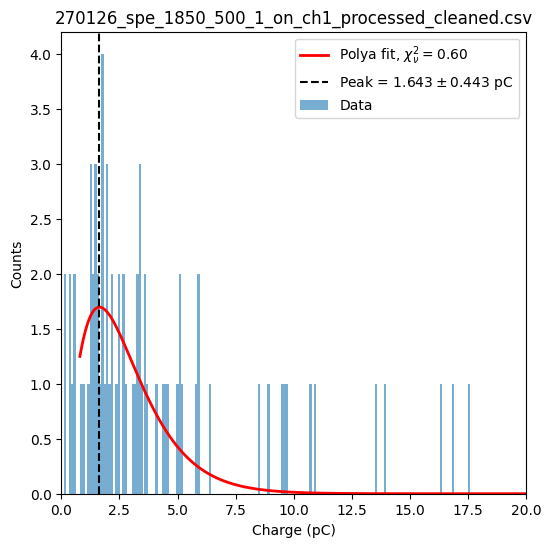

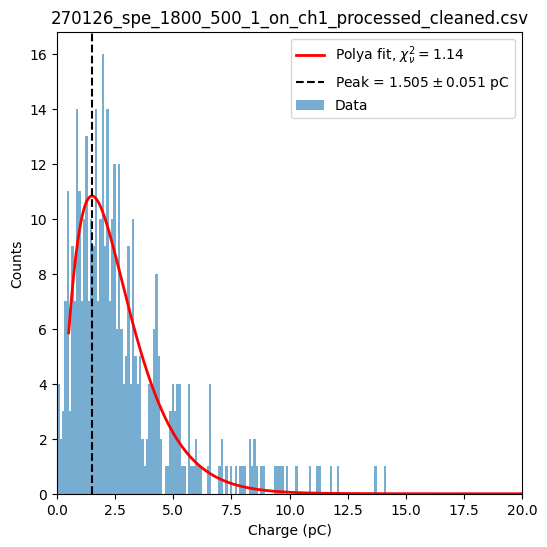

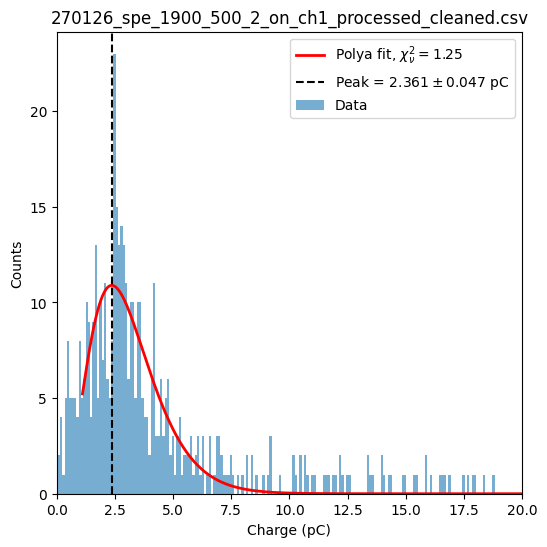

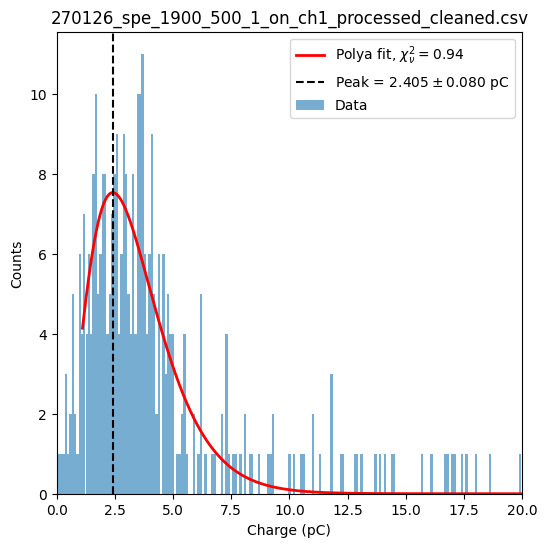

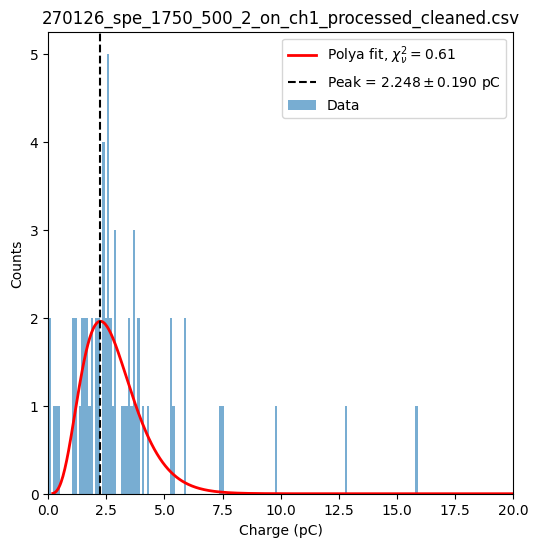

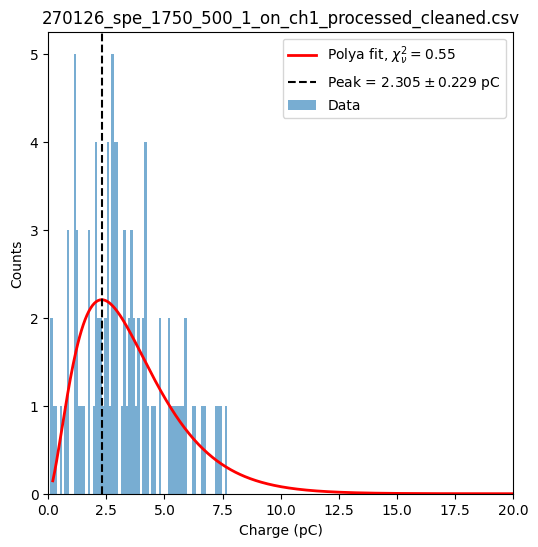

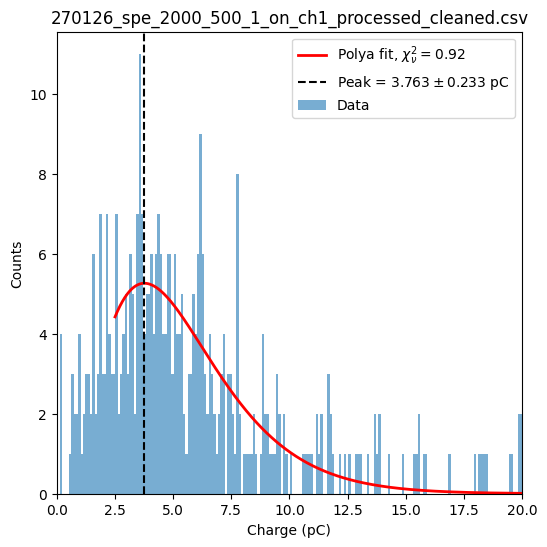

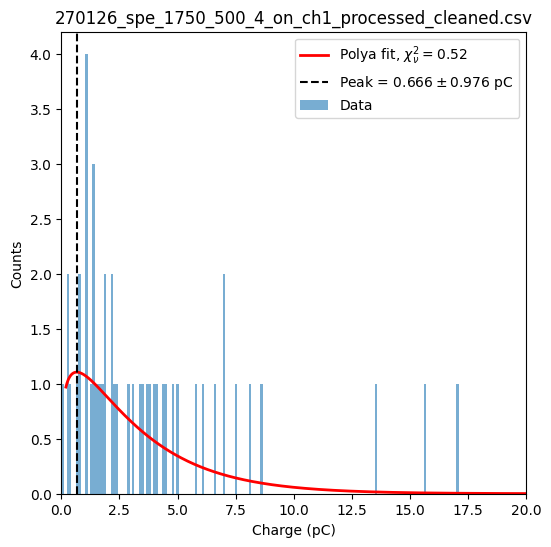

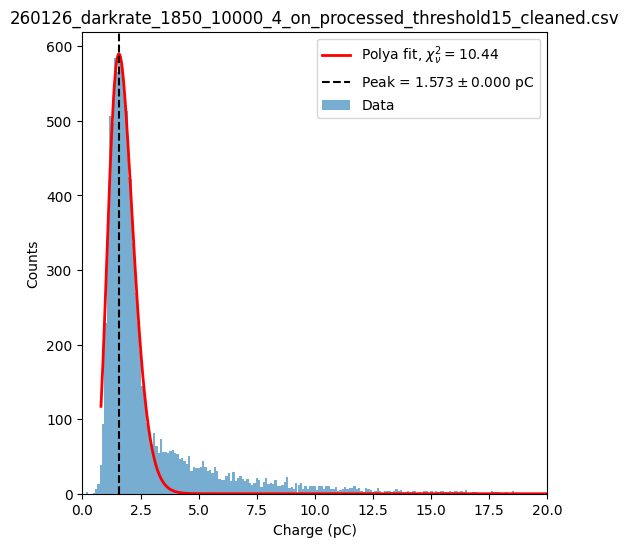

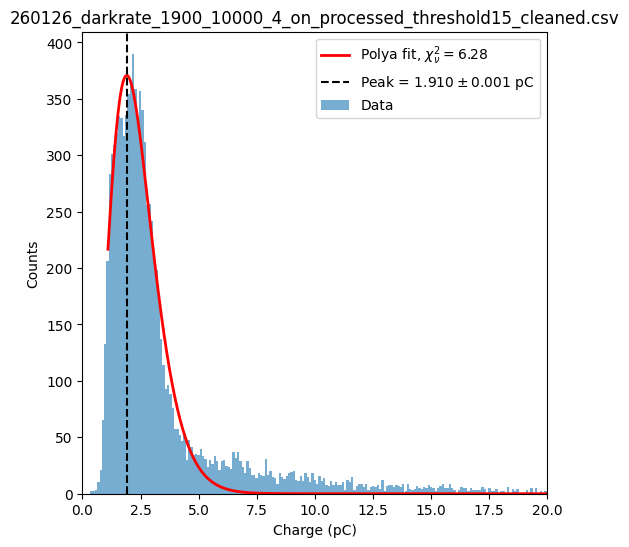

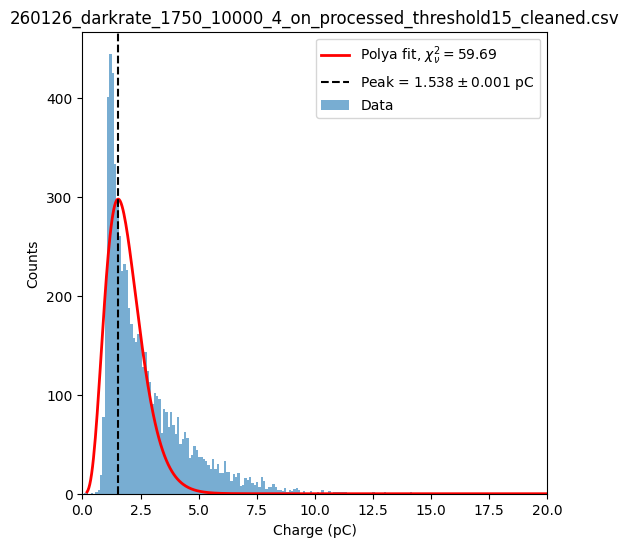

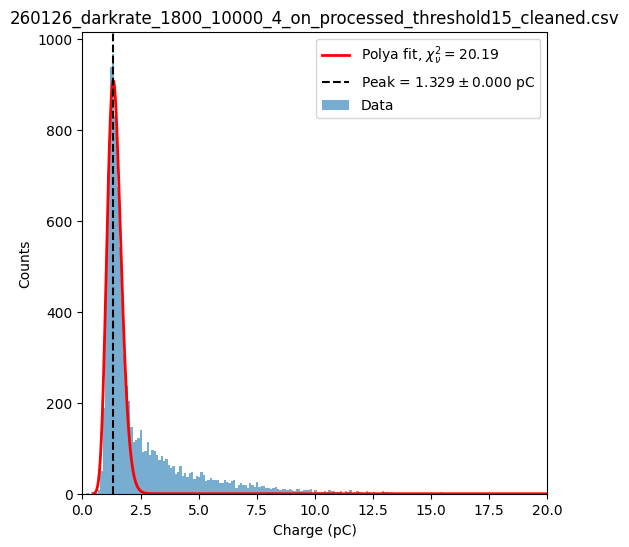

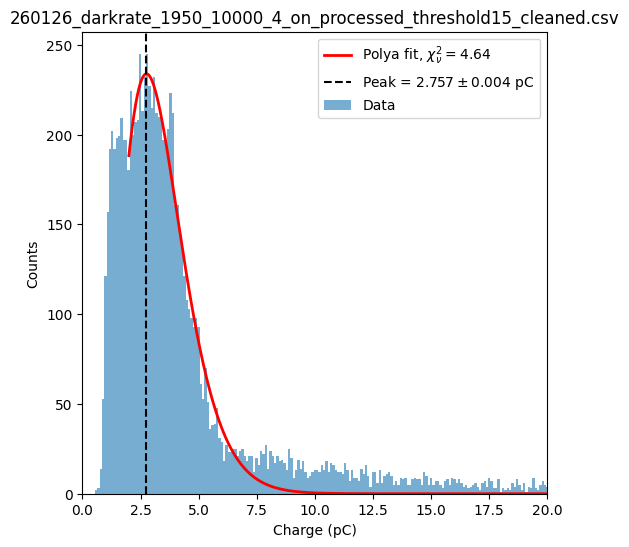

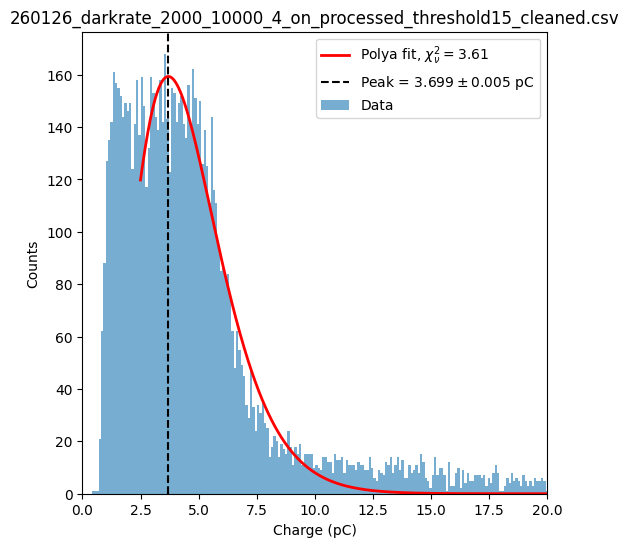

csvs outputted!


In [15]:
#get the voltage

def get_voltage(filepath):
    filename = os.path.basename(filepath)
    match = re.search(r'_(\d{3,4})_', filename)
    return int(match.group(1))


#loop over files with the relevant functions
spe_results = []

for file in spe_files:
    voltage = get_voltage(file)
    df = pd.read_csv(file)
    charge = df['integral_pC'].values

    if voltage == 2000:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 2.5, filename=file)
    if voltage == 1950:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 2, filename=file)
    if voltage == 1900:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 1.1, filename=file)
    if voltage == 1850:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.8, filename=file)
    if voltage == 1800:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.5, filename=file)
    if voltage == 1750:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.2, filename=file)

    spe_results.append({
        'voltage': voltage,
        'polya_peak_pC': peak,
        'polya_peak_error_pC': peak_err})
    
spe_df = pd.DataFrame(spe_results)
spe_df.sort_values('voltage', inplace=True)
spe_df.to_csv('PMT5_spe_masked_polya_peak_positions.csv', index=False)


darkrate_results = []

for file in darkrate_files:
    voltage = get_voltage(file)
    df = pd.read_csv(file)
    charge = df['integral_pC'].values

    if voltage == 2000:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 2.5, filename=file)
    if voltage == 1950:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 2, filename=file)
    if voltage == 1900:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 1.1, filename=file)
    if voltage == 1850:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.8, filename=file)
    if voltage == 1800:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.5, filename=file)
    if voltage == 1750:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut = 0.2, filename=file)
    
    darkrate_results.append({
        'voltage': voltage,
        'polya_peak_pC': peak,
        'polya_peak_error_pC': peak_err
    })

dark_df = pd.DataFrame(darkrate_results)
dark_df.sort_values('voltage', inplace=True)
dark_df.to_csv('PMT5_darkrate_masked_polya_peak_positions.csv', index=False)

print('csvs outputted!')